In [ ]:
"""
input:
    - monthly_fisher_exact_test_results_for_us_tweets.parquet
    - monthly_fisher_exact_test_results_for_world_tweets.parquet
    - fisher_exact_test_results_date.parquet
    - daily_fisher_exact_test_results_for_us_tweets.parquet
output:
    - correlation_of_locational_and_nonlocational_tweets.svg
    - timebased_atv_lineplot_locational_nonlocational.svg
"""

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.metrics import r2_score

from src.scripts.tools import Tools

In [ ]:
dataframes_path = "/data/processed/dataframes"
supp_figures_path = "/figures/experimental/supp_figures"

In [ ]:
us_df = pd.read_csv(f"{dataframes_path}/monthly_fisher_exact_test_results_for_us_tweets.parquet")
world_df = pd.read_csv(f"{dataframes_path}/monthly_fisher_exact_test_results_for_world_tweets.parquet")

In [ ]:
corr, p_val = spearmanr(us_df['odd_ratios'].values, world_df['odd_ratios'].values)
r2 = r2_score(us_df['odd_ratios'].values, world_df['odd_ratios'].values)

In [ ]:
plot_df = pd.DataFrame({"locational_tweets": us_df['odd_ratios'].values,
                        "non_locational_tweets": world_df['odd_ratios'].values})

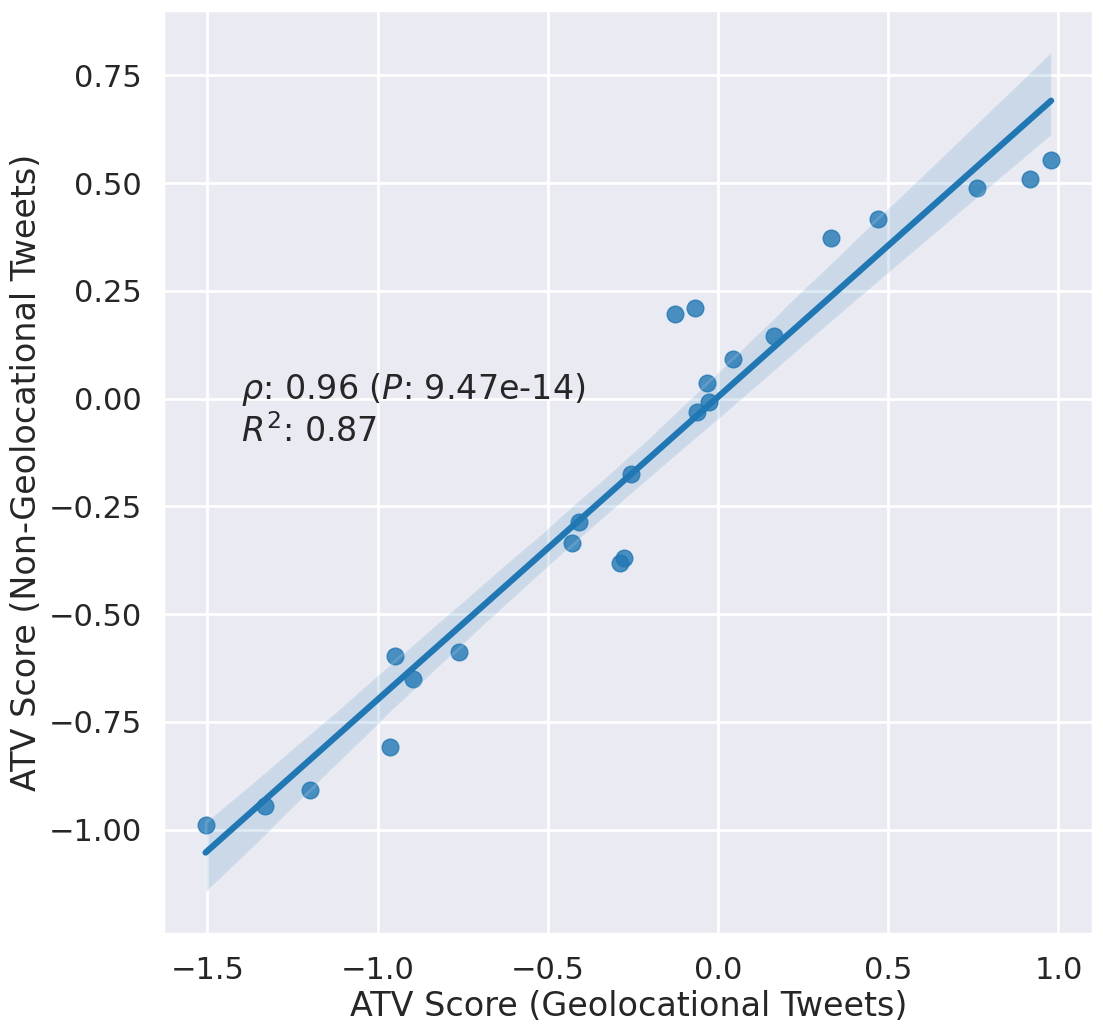

In [ ]:
sns.set_style("darkgrid")
plt.figure(figsize=(12, 12))
sns.set_context("poster")

sns.scatterplot(data=plot_df, x='locational_tweets', y='non_locational_tweets', s=0)
sns.regplot(data=plot_df, x='locational_tweets', y='non_locational_tweets')
plt.xlabel("ATV Score (Geolocational Tweets)")
plt.ylabel("ATV Score (Non-Geolocational Tweets)")
plt.text(-1.4, -0.1, f"$\\rho$: {corr:.2} ($P$: {p_val:.2e})\n$R^2$: {r2:.2}")
plt.savefig(f"{supp_figures_path}/locational_and_nonlocational_tweets_correlation.svg", bbox_inches='tight')

### Daily ATV Scores

In [ ]:
tools = Tools()

In [ ]:
daily_world_df = pd.read_csv(f"{dataframes_path}/fisher_exact_test_results_date.parquet")
daily_us_df = pd.read_csv(f"{dataframes_path}/daily_fisher_exact_test_results_for_us_tweets.parquet")

daily_us_df = daily_us_df.rename(columns={'date':'created_at'})

In [ ]:
tools.smooth_data(daily_world_df, smoothing_steps=1, columns='odd_ratios')
tools.smooth_data(daily_us_df, smoothing_steps=1, columns='odd_ratios')

In [ ]:
daily_world_df.head()

,created_at,tweet_counts,padj,odd_ratios
0,2020-01-01,965,0.666500,-0.084875
1,2020-01-02,1569,6.807586,0.038999
2,2020-01-03,1370,6.470302,0.086137
3,2020-01-04,1000,0.626333,0.099125
4,2020-01-05,989,1.780689,0.099816


In [ ]:
lineplot_df = daily_world_df[['created_at', 'odd_ratios']].join(
    daily_us_df[['created_at', 'odd_ratios']].set_index('created_at'), on='created_at', rsuffix='_us')

lineplot_df = lineplot_df.melt(id_vars='created_at', value_name='odd_ratio').sort_values('created_at').reset_index(drop=True)
lineplot_df['created_at'] = pd.to_datetime(lineplot_df['created_at'])

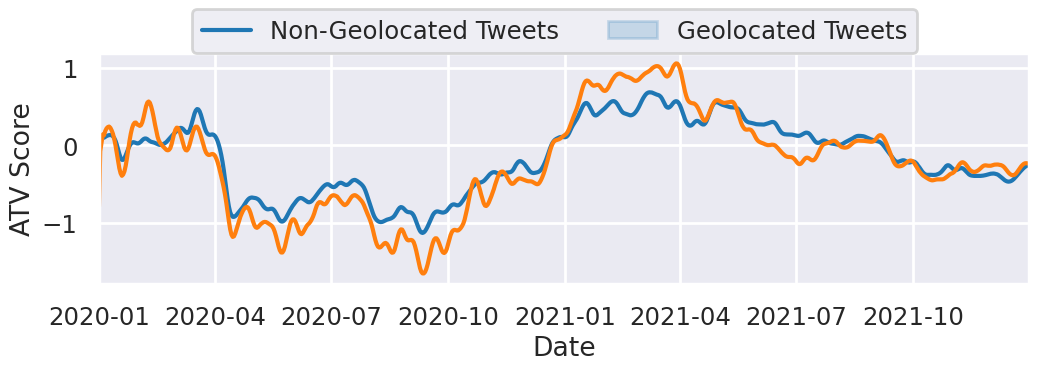

In [ ]:
sns.set_context("poster", 0.8)

fig, ax = plt.subplots(1, 1, figsize=(12, 3))
sns.lineplot(data=lineplot_df, x='created_at', y='odd_ratio', hue='variable', ax=ax)

plt.xlabel("Date")
plt.ylabel("ATV Score")
plt.margins(x=0)

plt.legend(["Non-Geolocated Tweets", 'Geolocated Tweets'], ncol=2, loc=(0.1, 1))
plt.savefig(f"{supp_figures_path}/timebased_atv_lineplot_locational_nonlocational.svg", bbox_inches='tight')